# Default Loan Classification

This notebook shows my work of building a baseline binary classification model using Random Forest to predict if there will be a default on the loan (`status` of `B` or `D`).

## Table of Content

1. [Connect to MySQL Database](#mysql)
2. Exploratory Data Analysis (In the other notebook)
3. [Feature Extraction](#feature_extraction)
4. [Correlation](#correlation)
5. [Transformation](#transformation)
6. [Modeling](#modeling)
7. [Feature Importance](#feature_importance)
8. [Future Directions](#future)

<a name='mysql'></a>
## 1. Connect to MySQL Database

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class MysqlIO:
    """Connect to MySQL server with python and excecute SQL commands."""
    def __init__(self, database='test'):
        try:
            # Change the host, user and password as needed
            connection = mysql.connector.connect(host='localhost',
                                                 database=database,
                                                 user='Zhou',
                                                 password='jojojo',
                                                 use_pure=True
                                                 )
            if connection.is_connected():
                db_info = connection.get_server_info()
                print("Connected to MySQL Server version", db_info)
                print("Your're connected to database:", database)
                self.connection = connection
        except Exception as e:
            print("Error while connecting to MySQL", e)
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe."""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [3]:
db = MysqlIO('bank')

Connected to MySQL Server version 8.0.21
Your're connected to database: bank


<a name='feature_extraction'></a>
## 3. Extract Features

The EDA is done in the notebook `EDA.ipynb`, so according to the results, I am going to pick some of those features and put them in a table and prepare for ML

### From Loan, Account, District

In [4]:
query = """
    select account_id, Loan.date date_loan, amount, duration, payments, status, frequency, Account.date date_acc,
        A4, A11, A12, A13, A14, A15, A16
    from Loan join Account using(account_id)
    join District using(district_id)"""
df = db.to_df(query)

In [5]:
df.set_index('account_id', inplace=True)

In [6]:
df['date_loan'] = pd.to_datetime(df.date_loan, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')
df['days_between'] = (df['date_loan'] - df['date_acc']).dt.days
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']
df['default'] = (df['status'] == 'B') | (df['status'] == 'D')

### From Order

In [7]:
query = """
    select account_id, amount order_amount
    from `Order`
    where account_id in (
        select account_id
        from Loan);
    """
df_order = db.to_df(query)

In [8]:
df_order['order_amount'] = df_order.order_amount.astype('float')
df = df.join(df_order.groupby('account_id').mean())
df = df.rename(columns={'order_amount': 'average_order_amount'})

### From Transaction

In [9]:
query = """
    select account_id, amount trans_amount, balance trans_balance
    from Trans
    where account_id in (
        select account_id
        from Loan);
    """
df_trans = db.to_df(query)

In [10]:
n_trans = df_trans.groupby('account_id').count().iloc[:, 1]
n_trans.name = 'n_trans'

In [11]:
df_trans = df_trans.groupby('account_id').mean()
df_trans.columns = ['average_trans_amount', 'average_trans_balance']

In [12]:
df = df.join(df_trans).join(n_trans)

### From Card

In [13]:
query = """
    select account_id, Card.type card_type
    from Loan join Disposition using(account_id)
    left join Card using(disp_id)
    where Disposition.type = 'OWNER';
    """
df_card = db.to_df(query)

In [14]:
df = df.join(df_card.set_index('account_id'), how='left')
df['card_type'].fillna('No', inplace=True)

### From Owner

In [15]:
query = """
    select account_id, Loan.date loan_date, Account.district_id acc_dist_id, 
    Client.district_id cli_dist_id, gender owner_gender, birth_date
    from Loan join Account using(account_id)
    join Disposition using(account_id)
    join Client using(client_id)
    where Disposition.type = 'OWNER';
    """
df_cli = db.to_df(query)

In [16]:
df_cli['same_district'] = df_cli['acc_dist_id'] == df_cli['cli_dist_id']
df_cli['date'] = pd.to_datetime(df_cli['loan_date'], format='%Y-%m-%d')
df_cli['birth_date'] = pd.to_datetime(df_cli['birth_date'], format='%Y-%m-%d')
df_cli['owner_age'] = (df_cli['date'] - df_cli['birth_date']).dt.days // 365

In [17]:
df = df.join(df_cli.set_index('account_id')[['same_district', 'owner_gender', 'owner_age']])

### The final feature list

In [18]:
df_ml = df[['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate', 'average_order_amount', 'average_trans_amount',
            'average_trans_balance', 'n_trans', 'owner_age', 
            'frequency', 'card_type', 'same_district', 'owner_gender', 'default']]

In [19]:
df_ml.sample(10)

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,average_order_amount,average_trans_amount,average_trans_balance,n_trans,owner_age,frequency,card_type,same_district,owner_gender,default
account_id,,,,,,,,,,,,,,,,,,,
2165,78600,24,3275.00,136,121947,8541,0.99,131,0.030075,7883.90,7463.032258,30019.911290,124,41,POPLATEK MESICNE,No,True,male,False
7523,288468,36,8013.00,127,86513,8288,0.99,110,0.017466,8013.00,6060.621762,33971.818653,386,36,POPLATEK MESICNE,No,True,female,False
3137,253560,60,4226.00,645,119895,10446,0.99,90,0.040410,4226.50,10167.761905,40490.785714,126,47,POPLATEK MESICNE,No,True,female,False
1869,37944,36,1054.00,594,1204953,12541,0.36,167,0.076677,1054.00,9042.000000,67825.378698,169,31,POPLATEK MESICNE,classic,True,female,False
5181,399120,60,6652.00,450,138032,8819,0.99,99,0.031036,6652.50,6636.396104,39458.077922,154,54,POPLATEK MESICNE,No,True,female,False
1480,123300,36,3425.00,565,118650,9832,0.99,114,0.050215,3425.20,12860.913580,54359.858025,162,52,POPLATEK TYDNE,classic,True,female,False
4851,141648,24,5902.00,200,139012,8363,0.99,108,0.019290,5093.60,12159.400862,47859.370690,232,44,POPLATEK MESICNE,No,True,male,False
5385,149340,60,2489.00,321,105606,8254,0.99,97,0.021263,5621.65,5495.901639,35020.355972,427,31,POPLATEK TYDNE,No,True,male,False
4462,66480,24,2770.00,139,182027,8746,0.99,90,0.024139,2770.30,9752.944724,31561.552764,199,60,POPLATEK TYDNE,No,True,male,True


<a name='correlation'></a>
## 4. Correlations

Quick check on the correlation between continuous variables.

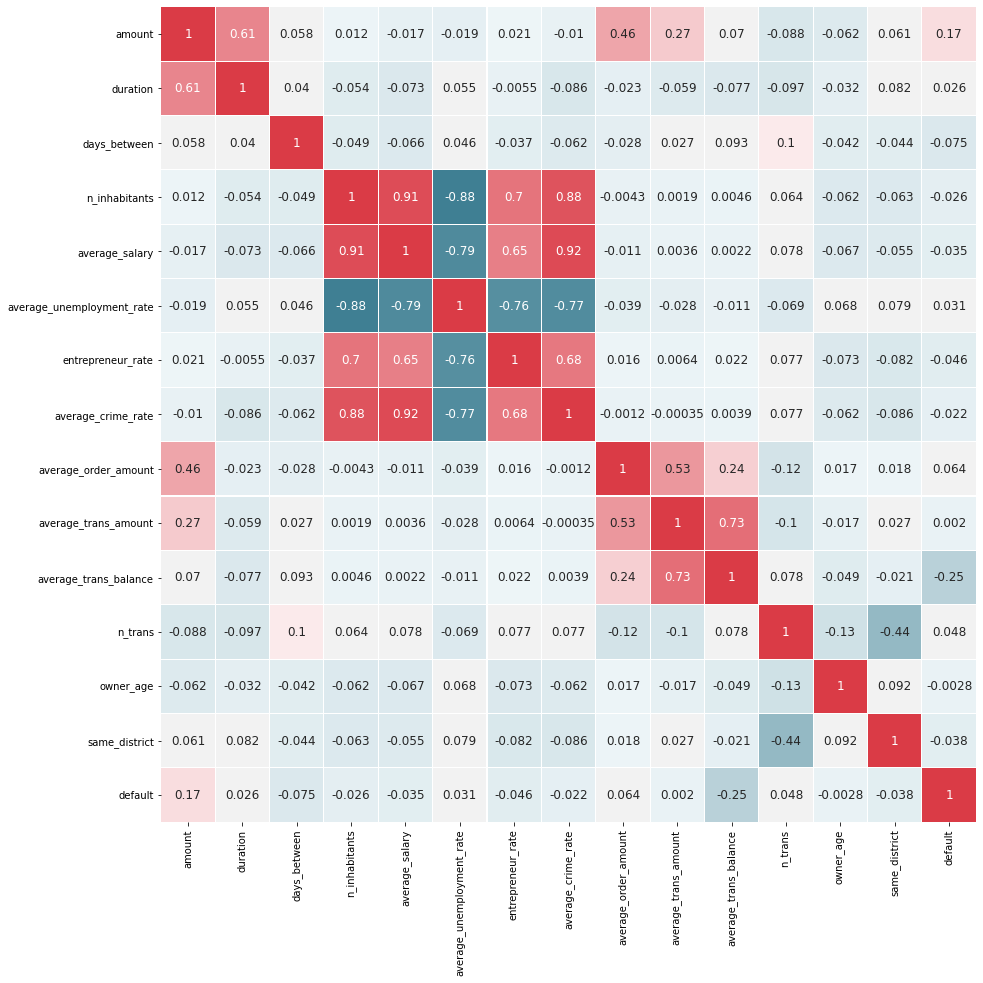

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
        df_ml.corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.show()

<a name='transformation'></a>
## 5. Transformations

Quick transformations: numeric variables are scaled using `MinMaxScaler` and the categorical variables are one-hot encoded.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [22]:
num_cols = df_ml.columns[:-5]
cat_cols = df_ml.columns[-5:]

In [23]:
col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
])

In [24]:
df_transformed = col_trans.fit_transform(df_ml)
X = df_transformed[:, :-1]
y = df_transformed[:, -1]

<a name='modeling'></a>
## 6. Modeling

Again, this is just a baseline model, using RandomForestClassifier, which is one of the most popular and simplest models. The performance metrics are chosen to be accuracy, F1, ROC AUC. Also the confusion matrices are calculated.

In [25]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [26]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [27]:
# See the inital model performance
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

Acc: 0.8972807017543859
F1: 0.16200466200466201
ROC AUC: 0.725319582378406


### Fine tune

Finetuned using F1 Score.

In [28]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [29]:
clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1')

In [30]:
print(clf.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}


In [31]:
clf.best_score_

0.21410256410256415

### Refit using best params

In [32]:
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             random_state=11)

In [33]:
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=10, random_state=11)

### Performance on the training set

In [34]:
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)

In [35]:
print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))

Train Acc: 0.9706498951781971
Train F1: 0.8478260869565216
Train ROC AUC: 0.9951717693129227


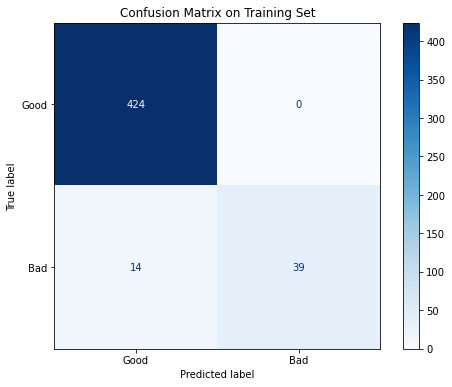

In [36]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, y_train, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Training Set')
plt.show()

### Performance on test set

In [37]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

In [38]:
print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))

test Acc: 0.8926829268292683
test F1: 0.26666666666666666
test ROC AUC: 0.6956521739130435


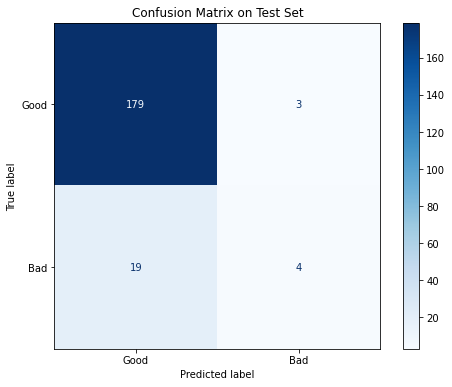

In [39]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Test Set')
plt.show()

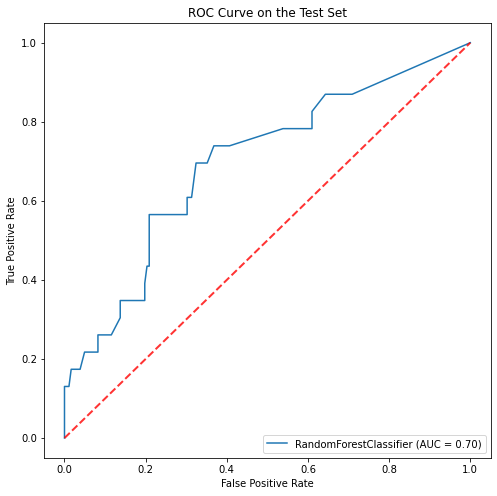

In [40]:
# ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve on the Test Set')
plt.show()

<a name='feature_importance'></a>
## 7. Feature Importance

The top 5 features that have the most prediction powers are:
- Average Transaction Balance
- Average Transaction Amount
- Loan Amount
- Average Salary
- Day between account creation and loan application  

They can be further studies if time permitted.

In [41]:
feature_names = num_cols.tolist() + col_trans.transformers_[1][1].get_feature_names().tolist()[:-1]
df_importance = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
df_importance.sort_values('importance', ascending=False)

,feature,importance
11,average_trans_balance,0.158538
10,average_trans_amount,0.118475
0,amount,0.096053
5,average_salary,0.085013
3,days_between,0.084768
2,payments,0.079096
13,owner_age,0.070534
12,n_trans,0.064940
4,n_inhabitants,0.057404
8,average_crime_rate,0.055937


<a name='future'></a>
## 8. Future Directions

1. **Extract more features**: Due to time limit, it is not possible to conduct a thorough study and have a deep understanding of the dataset. There are still many features in the dataset that are unused.
2. **Try other models**: Only the Random Forest model is used, but there are many good ones out there, such as Logistic Regression, XGBoost, SVM, or even neural networks.
3. **Deal with the unbalanced data**: It is important to notice this fact that the default loans are only about 10% of the total loans, so during the training process, the model will favor predicting more negatives than positive results. In order to solve this problem, we can collect more data or use resampling techniques.